In [2]:
!pip install torch-intermediate-layer-getter
!pip install umap-learn
!pip install leidenalg
!pip install scanpy==1.9.6
!pip install anndata umap-learn
!pip install watermark

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for torch-intermediate-layer-getter: filename=torch_intermediate_layer_getter-0.1.post1-py3-none-any.whl size=3724 sha256=a1d4a4fd058e802f08fafcd7b36362c1394d8a6e3bbdc5b6da19a8854cbd2913
  Stored in directory: /tmp/pip-ephem-wheel-cache-2urnypr1/wheels/6a/11/c0/30d81aa26172d10d68ffaf352b0762eb9fe0a5f5dcf3de63e0
Successfully built torch-intermediate-layer-getter
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bi

In [3]:
!pip install nexusformat

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 79 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 45.9 MB 7.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
import os
import wandb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
import sys
import seaborn as sn
from torch.utils.tensorboard import SummaryWriter
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
import umap
import scanpy as sc
import anndata as ad
import re
from collections import Counter
import random
from torch.utils.data import Subset
import h5py
import random
import pickle
import glob

from sparcscore.ml.datasets import HDF5SingleCellDataset
# from sparcscore.pipeline.project import TimecourseProject, Project
# from sparcscore.pipeline.workflows import MultithreadedWGATimecourseSegmentation, WGATimecourseSegmentation, MultithreadedCytosolCellposeTimecourseSegmentation, ShardedWGASegmentation, ShardedDAPISegmentationCellpose, WGASegmentation, DAPISegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction, TimecourseHDF5CellExtraction
#from sparcscore.pipeline.classification import MLClusterClassifier
#from sparcscore.ml.pretrained_models import autophagy_classifier2_1

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
!rm -rf /dss/dsshome1/0F/di93quv/.cache/*
!ls -lh /dss/dsshome1/0F/di93quv/.cache

total 0


## I. Make a feasible test set <a class="anchor" id="test-set"></a>

First, we want to look at where we have the data stored and how many slides, i.e. files, we have and then we create a test set containing instances from all biological classes. None of the instances from this test set should leak into any of our training runs. We use this same balanced test set across all emsembling runs.

In [5]:
full_hdf5_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_0d.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5'],
    dir_labels=[4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 3426407
0: 407464
1: 209030
2: 400000
3: 9346
4: 7476
5: 2393091


In [2]:
class HDF5SingleCellDataset(Dataset):
    """
    Class for handling SPARCSpy single cell datasets stored in HDF5 files.

    This class provides a convenient interface for SPARCSpy formated hdf5 files containing single cell datasets. It supports loading data
    from multiple hdf5 files within specified directories, applying transformations on the data, and returning
    the required information, such as label or id, along with the single cell data.

    Attributes
    ----------
    root_dir : str
        Root directory where the hdf5 files are located.
    dir_labels : list of int
        List of labels corresponding to the directories in dir_list.
    dir_list : list of str
        List of path(s) where the hdf5 files are stored. Supports specifying a path to a specific hdf5 file or directory
        containing hdf5 files.
    transform : callable, optional
        A optional user-defined function to apply transformations to the data. Default is None.
    max_level : int, optional
        Maximum levels of directory to search for hdf5 files. Default is 5.
    return_id : bool, optional
        Whether to return the index of the cell with the data. Default is False.
    return_fake_id : bool, optional
        Whether to return a fake index (0) with the data. Default is False.
    select_channel : int, optional
        Specify a specific channel to select from the data. Default is None, which returns all channels.

    Methods
    -------
    add_hdf_to_index(current_label, path)
        Adds single cell data from the hdf5 file located at ‘path’ with the specified ‘current_label’ to the index.
    scan_directory(path, current_label, levels_left)
        Scans directories for hdf5 files and adds their data to the index with the specified ‘current_label’.
    stats()
        Prints dataset statistics including total count and count per label.
    len()
        Returns the total number of single cells in the dataset.
    getitem(idx)
        Returns the data, label, and optional id/fake_id of the single cell specified by the index ‘idx’.

    Examples
    --------
    >>> hdf5_data = HDF5SingleCellDataset(dir_list=[‘data1.hdf5’, ‘data2.hdf5’],
    dir_labels=[0, 1],
    root_dir=‘/path/to/data’,
    transform=None,
    return_id=True)
    >>> len(hdf5_data)
    2000
    >>> sample = hdf5_data[0]
    >>> sample[0].shape
    torch.Size([1, 128, 128])
    >>> sample[1]
    tensor(0)
    >>> sample[2]
    tensor(0)

    """
    
    HDF_FILETYPES = ["hdf", "hf", "h5", "hdf5"]
    def __init__(self, dir_list, 
                 dir_labels, 
                 root_dir, 
                 max_level=5, 
                 transform=None, 
                 return_id=False, 
                 return_fake_id=False,
                 select_channel=None):
        
        self.root_dir = root_dir
        self.dir_labels = dir_labels
        self.dir_list = dir_list
        self.transform = transform
        
        self.handle_list = []
        self.data_locator = []
        
        self.select_channel = select_channel
        
        # scan all directoreis
        for i, directory in enumerate(dir_list):
            path = os.path.join(self.root_dir, directory)  
            current_label = self.dir_labels[i]

            #check if "directory" is a path to specific hdf5
            filetype = directory.split(".")[-1]
            filename = directory.split(".")[0]
                
            if filetype in self.HDF_FILETYPES:
                self.add_hdf_to_index(current_label, directory)

            else:
                # recursively scan for files
                self.scan_directory(path, current_label, max_level)
        
        # print dataset stats at the end
        
        self.return_id = return_id
        self.return_fake_id = return_fake_id
        self.stats()
        
        
    def add_hdf_to_index(self, current_label, path):       
        try:
            input_hdf = h5py.File(path, 'r')
            index_handle = input_hdf.get('single_cell_index')
            handle_id = len(self.handle_list)
            self.handle_list.append(input_hdf.get('single_cell_data'))

            # Track the size of the dataset (number of single cells)
            dataset_size = input_hdf.get('single_cell_data').shape[0]

            # Append the label, handle ID, and index range (from 0 to dataset_size-1)
            for row in index_handle:
                self.data_locator.append([current_label, handle_id, row[0]])  # row[0] = single cell index
                # Store additional boundary info if needed (e.g., start_idx, end_idx per dataset)
        except Exception as e:
            print(f"Error reading HDF5 file {path}: {e}")
            return

             
    def inspect_data_locator(self):
        print("Data Locator Contents:")
        for i, entry in enumerate(self.data_locator):
            print(f"Entry {i}: {entry}")

        
    def scan_directory(self, path, current_label, levels_left):
        
        # iterates over all files and folders in a directory
        # hdf5 files are added to the index
        # subfolders are recursively scanned
        
        if levels_left > 0:
            
            # get files and directories at current level
            input_list = os.listdir(path)
            current_level_directories = [os.path.join(path, name) for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

            current_level_files = [ name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]
                        
            for i, file in enumerate(current_level_files):
                filetype = file.split(".")[-1]
                filename = file.split(".")[0]
                
                if filetype in self.HDF_FILETYPES:
                    
                    self.add_hdf_to_index(current_label, os.path.join(path, file))
                    
            # recursively scan subdirectories        
            for subdirectory in current_level_directories:
                self.scan_directory(subdirectory, current_label, levels_left-1)
            
        else:
            return
        
    def stats(self):
    
        labels = [el[0] for el in self.data_locator]
        
        print("Total: {}".format(len(labels)))
        
        for l in set(labels):
            print("{}: {}".format(l,labels.count(l)))
        
    def __len__(self):
        return len(self.data_locator)
    
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the handle ID and cell index for the current dataset
        data_info = self.data_locator[idx]
        handle_id = data_info[1]
        cell_index = data_info[2]

        # Select the correct channel if needed
        if self.select_channel is not None:
            cell_tensor = self.handle_list[handle_id][cell_index, self.select_channel]
            t = torch.from_numpy(cell_tensor)
            t = torch.unsqueeze(t, 0)
        else:
            cell_tensor = self.handle_list[handle_id][cell_index]
            t = torch.from_numpy(cell_tensor)

        t = t.float()

        # Apply transformations if any
        if self.transform:
            t = self.transform(t)

        # Handle whether to return ID or fake ID
        if self.return_id and self.return_fake_id:
            raise ValueError("Either return_id or return_fake_id should be set, not both.")
        if self.return_id:
            sample = (t, torch.tensor(data_info[0]), torch.tensor(data_info[2]))  # Include the cell ID
        elif self.return_fake_id:
            sample = (t, torch.tensor(data_info[0]), torch.tensor(0))  # Return a fake ID (0)
        else:
            sample = (t, torch.tensor(data_info[0]))  # Just return the data and label

        return sample

Code for HDF5SingelcellDataset taken from: https://github.com/MannLabs/SPARCSpy/blob/main/src/sparcscore/ml/datasets.py

*Explanation of data_locator structure:*

For the example entry [4, 0, 0, 4], it means:

* Class Label: The cell belongs to class label 4.
* Handle ID: The data for this cell can be found in the first HDF5 file (index 0).
* Cell Index: Within that file, this is the first cell (index 0).
* Original ID: The original identifier of the cell is 4.

In [7]:
def sample_cells(dataset, class_label, n_samples, exclude_indices=[]):
    # Get all valid entries for the given class_label
    valid_entries = [entry for entry in dataset.data_locator if entry[0] == class_label]
    
    # entry[2] gives the index within that specific dataset
    cell_indices = [(entry[1], entry[2]) for entry in valid_entries]  # (handle_id, cell_index) tuple
    
    # Remove excluded indices 
    cell_indices = [ci for ci in cell_indices if ci[1] not in exclude_indices]

    # ccheck if the available cells are fewer than requested
    if len(cell_indices) < n_samples:
        print(f"Warning: Requested {n_samples} samples, but only {len(cell_indices)} available.")
        n_samples = len(cell_indices)
    
    sampled_indices = random.sample(cell_indices, n_samples) # Returns (handle_id, cell_index) pairs
    
    return sampled_indices  

#### Balanced Test set

In [8]:
##### New
def create_testset(dataset, test_filename_template, number):
    testset_indices = {}

    # For each class, sample cells and collect them
    for class_label in range(6):  # Assuming 6 classes
        print(f"Sampling for class {class_label}")
        sampled_cell_indices = sample_cells(dataset, class_label, number)
        testset_indices[class_label] = sampled_cell_indices

        # Save each class test set to a separate HDF5 file
        test_filename = test_filename_template.format(label=class_label)

        with h5py.File(test_filename, 'w') as f:
            # Lists to store data before writing to HDF5
            cell_data_list = []
            cell_index_list = []
            annotation_list = []

            # Track local index (starting from 0 for each new file)
            local_index = 0

            # Loop over the sampled cell indices
            for global_cell_id, (handle_id, cell_index) in enumerate(sampled_cell_indices):
                # Retrieve the correct entry from data_locator using (handle_id, cell_index) pair
                entry = next((entry for entry in dataset.data_locator if entry[1] == handle_id and entry[2] == cell_index), None)

                if entry is None:
                    print(f"Warning: No entry found for handle_id {handle_id} and cell_index {cell_index}. Skipping.")
                    continue

                try:
                    # Retrieve the single-cell data from the correct handle
                    data = dataset.handle_list[handle_id][cell_index]
                except KeyError:
                    print(f"Error: Data not found for handle_id {handle_id}, cell_index {cell_index}.")
                    continue

                # The class label (from the data locator)
                label = entry[0]

                # Append data and the corresponding local index for this file
                cell_data_list.append(data)
                
                # Use local_index (for the new test file) and the original cell_index from the HDF5 file
                cell_index_list.append([local_index, local_index])  # Use local_index and the global cell_index
                
                # Annotation: store local_index, original cell_index, and class label as encoded strings
                annotation_list.append([str(local_index).encode(), str(cell_index).encode(), str(label).encode()])

                local_index += 1  # Increment the local index for each cell

            # Convert lists to numpy arrays before saving
            if len(cell_data_list) > 0:
                single_cell_data = np.array(cell_data_list, dtype='float16')  # Shape: (n_cells, channels, height, width)
                single_cell_index = np.array(cell_index_list, dtype=np.uint64)  # Shape: (n_cells, 2)
                annotation = np.array(annotation_list, dtype='S')  # Shape: (n_cells, 3), string-encoded data

                # Write to HDF5
                f.create_dataset('single_cell_data', data=single_cell_data, dtype='float16')
                f.create_dataset('single_cell_index', data=single_cell_index, dtype='uint64')
                f.create_dataset('annotation', data=annotation, dtype=h5py.special_dtype(vlen=bytes))
            else:
                print(f"Warning: No valid data found for class {class_label}.")
    
    return testset_indices

##### Create big balanced testset with instances from all biological classes

In [3]:
import os
os.chdir('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/')
files = os.listdir()
for file in files:
    print(file)
print("\n")

balanced_testset.pt
testset_0.h5
testset_1.h5
testset_indices.pkl
testset_5.h5
testset_3.h5
testset_4.h5
testset_2.h5




In [17]:
directory = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/'
file_pattern = os.path.join(directory, 'testset_*.h5')

# Get a list of all matching files
files_to_delete = glob.glob(file_pattern)

# Loop through files and delete them
for file_path in files_to_delete:
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except OSError as e:
        print(f"Error deleting file {file_path}: {e}")

# checking if any files remain
remaining_files = glob.glob(file_pattern)
if not remaining_files:
    print("All files deleted successfully.")
else:
    print(f"Remaining files: {remaining_files}")

Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_0.h5
Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_1.h5
Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_5.h5
Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_3.h5
Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_4.h5
Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_2.h5
All files deleted successfully.


In [18]:
test_filename_template = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_{label}.h5'

# Create test set with separate files for each class
testset_indices = create_testset(full_hdf5_data, test_filename_template, 7000)

Sampling for class 0
Sampling for class 1
Sampling for class 2
Sampling for class 3
Sampling for class 4
Sampling for class 5


In [ ]:
#Having a look if the test set has been created properly by looking into he h5 file
#import nexusformat.nexus as nx
#f = nx.nxload('./testset_0.h5')
#print(f.tree)

In [19]:
# Now, create balanced dataset from the saved files
balanced_testset_all_classes = HDF5SingleCellDataset(
    dir_list=[f'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_{label}.h5' for label in range(6)],
    dir_labels=[0, 1, 2, 3, 4, 5],  # class labels
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/',  
    select_channel=4,  # Select the 5th channel
    return_id=False
)

Total: 42000
0: 7000
1: 7000
2: 7000
3: 7000
4: 7000
5: 7000


In [20]:
# Save the testset_indices to a file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_indices.pkl', 'wb') as f:
    pickle.dump(testset_indices, f)

In [16]:
# Load the testset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_indices.pkl', 'rb') as f:
    testset_indices = pickle.load(f)

##### Create small balanced testset with instances from all biological classes

In [6]:
directory = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/'
file_pattern = os.path.join(directory, 'testset_*.h5')

# Get a list of all matching files
files_to_delete = glob.glob(file_pattern)

# Loop through the files and delete them
for file_path in files_to_delete:
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except OSError as e:
        print(f"Error deleting file {file_path}: {e}")

# checking if any files remain
remaining_files = glob.glob(file_pattern)
if not remaining_files:
    print("All files deleted successfully.")
else:
    print(f"Remaining files: {remaining_files}")

Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_0.h5
Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_1.h5
Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_5.h5
Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_3.h5
Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_4.h5
Deleted: /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_2.h5
All files deleted successfully.


In [7]:
# Define the template for the testset filenames
test_filename_template = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_{label}.h5'

# Create test set with separate files for each class
testset_indices = create_testset(full_hdf5_data, test_filename_template, 50)

Sampling for class 0
Sampling for class 1
Sampling for class 2
Sampling for class 3
Sampling for class 4
Sampling for class 5


In [8]:
# Now, create balanced dataset from the saved files
balanced_testset_all_classes = HDF5SingleCellDataset(
    dir_list=[f'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_{label}.h5' for label in range(6)],
    dir_labels=[0, 1, 2, 3, 4, 5],  # class labels
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/',  
    select_channel=4,  # Select the 5th channel
    return_id=False
)

Total: 300
0: 50
1: 50
2: 50
3: 50
4: 50
5: 50


In [9]:
def print_dataset_info(hdf5_filename):
    with h5py.File(hdf5_filename, 'r') as f:
        # Get the dataset
        single_cell_index = f['single_cell_index']

        # Print dataset details
        print(f"Key: single_cell_index")
        print(f"Shape: {single_cell_index.shape}")
        print(f"Data type: {single_cell_index.dtype}")

        # Print the first 5 rows of data as a sample
        sample_data = single_cell_index[:5]  # Slice first 5 rows
        print(f"Sample data (first 5 rows):")
        for row in sample_data:
            print(f"[{row[0]} {row[1]}]  # Local index {row[0]}, cell index {row[1]}")

# Example usage:
test_filename = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_1.h5"  # Replace this with the actual filename
print_dataset_info(test_filename)

Key: single_cell_index
Shape: (50, 2)
Data type: uint64
Sample data (first 5 rows):
[0 0]  # Local index 0, cell index 0
[1 1]  # Local index 1, cell index 1
[2 2]  # Local index 2, cell index 2
[3 3]  # Local index 3, cell index 3
[4 4]  # Local index 4, cell index 4


In [10]:
def print_unique_labels(hdf5_filename):
    with h5py.File(hdf5_filename, 'r') as f:
        # Access the 'annotation' dataset
        annotation = f['annotation']

        # Extract the labels (3rd column), and decode them from bytes to strings
        labels = [entry[2].decode() for entry in annotation[:]]

        # Find unique labels using numpy
        unique_labels = np.unique(labels)

        # Print the unique labels
        print(f"Unique labels in {hdf5_filename}:")
        for label in unique_labels:
            print(label)

# Example usage:
test_filename = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_1.h5"
print_unique_labels(test_filename)

Unique labels in /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_1.h5:
1


In [11]:
# Save the testset_indices to a file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_indices.pkl', 'wb') as f:
    pickle.dump(testset_indices, f)

In [52]:
# Load the testset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_indices.pkl', 'rb') as f:
    testset_indices = pickle.load(f)

Check if we can iterte through resulting dataset and visualize images properly

In [12]:
test_filename = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_0.h5'
with h5py.File(test_filename, 'r') as f:
    print(f.keys())
    print(f['single_cell_data'].shape)
    print(f['single_cell_index'].shape)
    print(f['annotation'][:5])  

<KeysViewHDF5 ['annotation', 'single_cell_data', 'single_cell_index']>
(50, 5, 128, 128)
(50, 2)
[[b'0' b'27029' b'0']
 [b'1' b'84429' b'0']
 [b'2' b'80504' b'0']
 [b'3' b'68885' b'0']
 [b'4' b'98243' b'0']]


In [13]:
image_data, label = balanced_testset_all_classes[0] 
print(image_data)
print(label)
print(f"Image data shape: {image_data.shape}, Label: {label}")

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(0)
Image data shape: torch.Size([1, 128, 128]), Label: 0


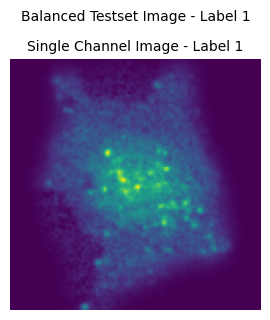

In [14]:
image_data, label = balanced_testset_all_classes[50]  # Unpack image data, label from tupel
num_channels = image_data.shape[0]  # number of channels

if num_channels == 1:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(image_data[0]) 
    ax.set_title(f"Single Channel Image - Label {label}", fontsize=10)
    ax.axis('off')

else:
    # create a subplot for each channel
    fig, axes = plt.subplots(1, num_channels, figsize=(10, 5))
    
    for channel in range(num_channels):
        axes[channel].imshow(image_data[channel])
        axes[channel].set_title(f"Channel {channel + 1}")
        axes[channel].axis('off')
        
plt.tight_layout()
plt.suptitle(f"Balanced Testset Image - Label {label}", fontsize=10, y=1.05)
plt.show()

#### Balanced Training sets

In [34]:
"""def create_trainset(dataset, train_filename_template, testset_indices, class_labels, n_samples_per_class=100000):
    trainset_indices = {}

    # Flatten testset indices so that we can exclude them from the training set
    testset_all_indices = set([(entry[0], entry[1]) for entries in testset_indices.values() for entry in entries])

    # Sample cells from the selected classes, excluding testset indices
    for class_label in class_labels:
        print(class_label)
        # Sample cells and exclude those that are already in the test set
        sampled_cell_indices = sample_cells(dataset, class_label, n_samples_per_class, exclude_indices=testset_all_indices)
        trainset_indices[class_label] = sampled_cell_indices
        
        # Save each class' training set to a separate HDF5 file
        train_filename = train_filename_template.format(label=class_label)
        
        with h5py.File(train_filename, 'w') as f:
            # Create lists to store data before writing to HDF5
            cell_data_list = []
            cell_index_list = []
            annotation_list = []
            
            # Loop over the sampled cell indices
            for global_cell_id, (handle_id, cell_index) in enumerate(sampled_cell_indices):
                # Retrieve the correct entry from data_locator using (handle_id, cell_index) pair
                entry = next((entry for entry in dataset.data_locator if entry[1] == handle_id and entry[2] == cell_index), None)
                
                if entry is not None:
                    # Get the actual data from the dataset handle list
                    data = dataset.handle_list[handle_id][cell_index] 
                    label = entry[0]  # Class label from the entry
                    
                    # Create annotation: (global_cell_id, original cell index, class label)
                    annotation_list.append([str(global_cell_id).encode(), str(cell_index).encode(), str(label).encode()])
                    
                    # Append data and index
                    cell_data_list.append(data)
                    cell_index_list.append([handle_id, cell_index])  # (handle_id, cell_index)
            
            # Convert lists to numpy arrays
            if cell_data_list:  
                single_cell_data = np.array(cell_data_list, dtype='float16')  # Shape: (n_cells, channels, height, width)
                single_cell_index = np.array(cell_index_list, dtype=np.uint64)  # Shape: (n_cells, 2)
                annotation = np.array(annotation_list, dtype='S')  # Shape: (n_cells, 3), string-encoded data
                
                # Write to HDF5
                f.create_dataset('single_cell_data', data=single_cell_data, dtype='float16')
                f.create_dataset('single_cell_index', data=single_cell_index, dtype='uint64')
                f.create_dataset('annotation', data=annotation, dtype=h5py.special_dtype(vlen=bytes))
            else:
                print(f"Warning: No data found for class label {class_label}.")
    
    return trainset_indices"""

In [ ]:
def create_trainset(dataset, train_filename_template, testset_indices, class_labels, n_samples_per_class=100000):
    trainset_indices = {}

    # Flatten testset indices so that we can exclude them from the training set
    testset_all_indices = set([(entry[0], entry[1]) for entries in testset_indices.values() for entry in entries])

    # Sample cells from the selected classes, excluding testset indices
    for class_label in class_labels:
        print(f"Sampling for class {class_label}")
        
        # Sample cells and exclude those that are already in the test set
        sampled_cell_indices = sample_cells(dataset, class_label, n_samples_per_class, exclude_indices=testset_all_indices)
        trainset_indices[class_label] = sampled_cell_indices
        
        # Save each class' training set to a separate HDF5 file
        train_filename = train_filename_template.format(label=class_label)
        
        with h5py.File(train_filename, 'w') as f:
            # Create lists to store data before writing to HDF5
            cell_data_list = []
            cell_index_list = []
            annotation_list = []
            
            # Track local index (starting from 0 for each new file)
            local_index = 0
            
            # Loop over the sampled cell indices
            for global_cell_id, (handle_id, cell_index) in enumerate(sampled_cell_indices):
                # Retrieve the correct entry from data_locator using (handle_id, cell_index) pair
                entry = next((entry for entry in dataset.data_locator if entry[1] == handle_id and entry[2] == cell_index), None)
                
                if entry is None:
                    print(f"Warning: No entry found for handle_id {handle_id} and cell_index {cell_index}. Skipping.")
                    continue

                try:
                    # Retrieve the single-cell data from the correct handle
                    data = dataset.handle_list[handle_id][cell_index] 
                except KeyError:
                    print(f"Error: Data not found for handle_id {handle_id}, cell_index {cell_index}.")
                    continue

                # The class label (from the data locator)
                label = entry[0]  # Class label from the entry

                # Append data and the corresponding local index for this file
                cell_data_list.append(data)
                
                # Use local_index (for the new train file) and the original cell_index
                cell_index_list.append([local_index, local_index])  # Use local_index and the original cell_index
                
                # Annotation: store local_index, original cell_index, and class label as encoded strings
                annotation_list.append([str(local_index).encode(), str(cell_index).encode(), str(label).encode()])

                local_index += 1  # Increment the local index for each cell

            # Convert lists to numpy arrays before saving
            if len(cell_data_list) > 0:
                single_cell_data = np.array(cell_data_list, dtype='float16')  # Shape: (n_cells, channels, height, width)
                single_cell_index = np.array(cell_index_list, dtype=np.uint64)  # Shape: (n_cells, 2)
                annotation = np.array(annotation_list, dtype='S')  # Shape: (n_cells, 3), string-encoded data

                # Write to HDF5
                f.create_dataset('single_cell_data', data=single_cell_data, dtype='float16')
                f.create_dataset('single_cell_index', data=single_cell_index, dtype='uint64')
                f.create_dataset('annotation', data=annotation, dtype=h5py.special_dtype(vlen=bytes))
            else:
                print(f"Warning: No valid data found for class {class_label}.")
    
    return trainset_indices

In [ ]:
# Check for overlap between testset and trainset indices
def check_overlap(testset_indices, trainset_indices):
    testset_all_indices = set([idx for indices in testset_indices.values() for idx in indices])  # Flatten testset indices
    trainset_all_indices = set([idx for indices in trainset_indices.values() for idx in indices])  # Flatten trainset indices
    overlap = testset_all_indices.intersection(trainset_all_indices)
    
    if overlap:
        print(f"Warning: Overlapping indices found between testset and trainset: {overlap}")
    else:
        print("No overlap between testset and trainset.")

##### Case 1 Big training set balanced

In [ ]:
os.chdir('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset/')
files = os.listdir()
print("Files:")
for file in files:
    print(file)
print("\n")

In [ ]:
# Load the testset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/testset_indices.pkl', 'rb') as f:
    testset_indices = pickle.load(f)

In [ ]:
# Define the class labels to include in the training set
train_class_labels = [0, 2] 

# Create training set with separate files for selected class labels
train_filename_template = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset/trainset_{label}.h5'
trainset_indices = create_trainset(full_hdf5_data, train_filename_template, testset_indices, class_labels=train_class_labels, n_samples_per_class = 100000)
check_overlap(testset_indices, trainset_indices)

In [ ]:
balanced_trainset_class_0_and_2 = HDF5SingleCellDataset(
    dir_list=[f'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset/trainset_{label}.h5' for label in train_class_labels],
    dir_labels=train_class_labels,  # The class labels
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset/',  
    select_channel=4,  # Select the 5th channel
    return_id=False
)

In [ ]:
# Save the trainset_indices to a file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset/trainset_indices.pkl', 'wb') as f:
    pickle.dump(trainset_indices, f)

In [ ]:
# Load the trainset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset/trainset_indices.pkl', 'rb') as f:
    trainset_indices = pickle.load(f)

##### Case 1 Small training set balanced

In [ ]:
directory = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/'
file_pattern = os.path.join(directory, 'trainset_*.h5')

# Get a list of all matching files
files_to_delete = glob.glob(file_pattern)

# Loop through the files and delete them
for file_path in files_to_delete:
    try:
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    except OSError as e:
        print(f"Error deleting file {file_path}: {e}")

# checking if any files remain
remaining_files = glob.glob(file_pattern)
if not remaining_files:
    print("All files deleted successfully.")
else:
    print(f"Remaining files: {remaining_files}")

In [56]:
# Load the testset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes_small/testset_indices.pkl', 'rb') as f:
    testset_indices = pickle.load(f)

In [ ]:
# Define the class labels to include in the training set
train_class_labels = [0, 2] 

In [ ]:
# Create training set with separate files for selected class labels
train_filename_template = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/trainset_{label}.h5'
trainset_indices = create_trainset(full_hdf5_data, train_filename_template, testset_indices, class_labels=train_class_labels, n_samples_per_class = 100)
check_overlap(testset_indices, trainset_indices)

In [ ]:
balanced_trainset_class_0_and_2 = HDF5SingleCellDataset(
    dir_list=[f'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/trainset_{label}.h5' for label in train_class_labels],
    dir_labels=train_class_labels,  # The class labels
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/',  
    select_channel=4,  # Select the 5th channel
    return_id=False
)

In [ ]:
# Save the trainset_indices to a file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/trainset_indices.pkl', 'wb') as f:
    pickle.dump(trainset_indices, f)

In [5]:
# Load the trainset_indices from the file
with open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/training_sets/case1_balanced_trainingset_small/trainset_indices.pkl', 'rb') as f:
    trainset_indices = pickle.load(f)

In [ ]:
image_data, label = balanced_trainset_class_0_and_2[0]  # Unpack image data, label from tupel
num_channels = image_data.shape[0]  # number of channels

if num_channels == 1:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(image_data[0]) 
    ax.set_title(f"Single Channel Image - Label {label}", fontsize=10)
    ax.axis('off')

else:
    # create a subplot for each channel
    fig, axes = plt.subplots(1, num_channels, figsize=(10, 5))
    
    for channel in range(num_channels):
        axes[channel].imshow(image_data[channel])
        axes[channel].set_title(f"Channel {channel + 1}")
        axes[channel].axis('off')
        
plt.tight_layout()
plt.suptitle(f"Balanced Trainset Image - Label {label}", fontsize=10, y=1.05)
plt.show()

We do a big and small testset and training set where the small sets are used to test the ensemble code before running on the bigger sets.

# Make SMALL final balanced testset with 2000 instances per biological class WITH return_id = true

#### used across de novo model and ConvNeXt inference

In [3]:
# Rename current old balanced_testset.pt as a backup
import os

old_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt"
new_path = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset_old.pt"

os.rename(old_path, new_path)

In [34]:
!ls -l "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/"

total 7495296
-rw-rw---- 1 di93quv pn36po     394712 Jan 30 16:29 balanced_testset.pt
-rw-rw---- 1 di93quv pn36po  786529235 Nov 12 18:04 balanced_testset_old.pt
-rw-rw---- 1 di93quv pn36po 1147854336 Nov 10 15:28 testset_0.h5
-rw-rw---- 1 di93quv pn36po 1147854336 Nov 10 15:49 testset_1.h5
-rw-rw---- 1 di93quv pn36po 1147854336 Nov 10 16:06 testset_2.h5
-rw-rw---- 1 di93quv pn36po 1147854336 Nov 10 16:24 testset_3.h5
-rw-rw---- 1 di93quv pn36po 1147854336 Nov 10 16:26 testset_4.h5
-rw-rw---- 1 di93quv pn36po 1147854336 Nov 10 16:42 testset_5.h5
-rw-rw---- 1 di93quv pn36po     959366 Nov 10 16:42 testset_indices.pkl


In [9]:
full_testset_data = HDF5SingleCellDataset(
    dir_list=[
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5'
    ],
    dir_labels=[4, 4, 4, 5, 3, 3, 3, 0, 1, 2], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Selecting the 5th channel (channel index 4)
    return_id=True  # Now return_id is True to get the cell ids we want!!
)

Total: 789105
0: 100000
1: 100000
2: 100000
3: 5019
4: 3654
5: 480432


In [10]:
import torch
from torch.utils.data import DataLoader
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

def undersample_dataset(dataset, target_classes, n_instances=None, seed=None):
    """
    Undersamples the dataset so target_classes have equal number of instances.
    If n_instances is set, each class will have n_instances samples.
    
    Parameters:
    - dataset: PyTorch Dataset object containing the features (e.g., HDF5SingleCellDataset)
    - target_classes: the list of classes to undersample (e.g., [0, 2] for training)
    - n_instances: number of samples per class (None means use minimum of class sizes)
    - seed: random seed for reproducibility
    
    Returns:
    - undersampled_dataset: the undersampled dataset (list of samples)
    """
    np.random.seed(seed)
    undersampled_data = []
    
    for cls in target_classes:
        class_indices = [i for i, (_, label) in enumerate(dataset) if label == cls]
        if n_instances is None:
            n_instances = len(class_indices)
        
        # Randomly sample n_instances for each class
        sampled_indices = np.random.choice(class_indices, n_instances, replace=False)
        undersampled_data.extend([dataset[i] for i in sampled_indices])
    
    # Shuffle the dataset
    undersampled_data = shuffle(undersampled_data, random_state=seed)
    return undersampled_data

# Function to create balanced testset for classes 0-5
def create_balanced_testset(dataset, target_classes, n_instances_per_class):
    """
    Create a balanced testset with n_instances_per_class for each class in target_classes.
    
    Parameters:
    - dataset: HDF5SingleCellDataset
    - target_classes: list of classes 
    - n_instances_per_class: number of instances to sample per class
    
    Returns:
    - balanced_testset: list of (image_tensor, label, cell_id) tuples with balanced instances per class
    """
    balanced_data = []
    
    for cls in target_classes:
        print(f"Processing class {cls}...")
        class_indices = [i for i, (_, label, _) in enumerate(dataset) if label == cls]
        
        # Randomly sample n_instances_per_class for each class
        sampled_indices = np.random.choice(class_indices, n_instances_per_class, replace=False)
        balanced_data.extend([dataset[i] for i in sampled_indices])  # dataset[i] now returns (image, label, cell_id)

    # Shuffle balanced testset
    balanced_data = shuffle(balanced_data, random_state=42)  
    return balanced_data

In [11]:
batch_size = 64                    # Batch size for DataLoader
#batch_size = 1

In [12]:
# 1. Create balanced testset for classes 0-5 (fixed across all training processes)
n_test_instances_per_class = 2000   # Test instances for each class (0-5)

target_test_classes = [0, 1, 2, 3, 4, 5]
balanced_testset = create_balanced_testset(full_testset_data, target_test_classes, n_test_instances_per_class)

# Create test DataLoader (shared for all training processes)
test_data_loader = DataLoader(balanced_testset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

Processing class 0...
Processing class 1...
Processing class 2...
Processing class 3...
Processing class 4...
Processing class 5...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
# Extract labels correctly (ignoring image and cell ID)
test_labels = [label for _, label, _ in balanced_testset]

# Compute class distribution
unique, counts = np.unique(test_labels, return_counts=True)

# Print results
print(f"Test set class distribution (balanced): {dict(zip(unique, counts))}")

Test set class distribution (balanced): {0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 2000}


In [13]:
def save_dataset(dataset, save_path):
    """
    Save dataset with images, labels, and cell IDs.

    Parameters:
    - dataset: List of (image_tensor, label, cell_id) tuples
    - save_path: Path where the dataset should be saved
    """
    images_tensor = torch.stack([sample[0] for sample in dataset])  # Stack image tensors
    labels_tensor = torch.tensor([sample[1] for sample in dataset])  # Stack labels
    cell_ids_tensor = torch.tensor([sample[2] for sample in dataset])  # Stack cell IDs

    torch.save((images_tensor, labels_tensor, cell_ids_tensor), save_path)
    print(f"Dataset saved at {save_path}")

In [ ]:
# Save the balanced test dataset
save_dataset(
    balanced_testset,
    "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt"
)

In [14]:
def load_dataset(save_path, batch_size):
    """
    Load dataset with images, labels, and cell IDs.

    Parameters:
    - save_path: Path where the dataset is stored
    - batch_size: Batch size for DataLoader

    Returns:
    - DataLoader for the dataset
    """
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)

    # Create a TensorDataset from the loaded tensors
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Loaded dataset from {save_path}")
    return data_loader

In [ ]:
# Load the balanced test dataset
test_data_loader = load_dataset(
    "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt",
    batch_size=batch_size
)

In [ ]:
# Function to visualize a batch from DataLoader
def visualize_batch(data_loader):
    images, labels, cell_ids = next(iter(data_loader))  # Getting first batch

    # Convert tensors to numpy
    image_data = images[0].numpy()  
    label = labels[0].item()  # Convert label tensor to int
    cell_id = cell_ids[0].item()  # Convert cell ID tensor to int
    
    num_channels = image_data.shape[0]  # number of channels
    
    if num_channels == 1:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        ax.imshow(image_data[0]) 
        ax.set_title(f"Label: {label}, Cell ID: {cell_id}", fontsize=10)
        ax.axis('off')
    else:
        fig, axes = plt.subplots(1, num_channels, figsize=(10, 5))
        for channel in range(num_channels):
            axes[channel].imshow(image_data[channel])
            axes[channel].set_title(f"Channel {channel + 1}")
            axes[channel].axis('off')
        
    plt.tight_layout()
    plt.suptitle(f"Batch Image - Label: {label}, Cell ID: {cell_id}", fontsize=10, y=1.05)
    plt.show()

# Visualize a batch from the test DataLoader
visualize_batch(test_data_loader)

# Make BIG final balanced testset with 10000 instances for class 5 and 2000 for all other classes WITH return_id = true

#### used across de novo model and ConvNeXt inference

In [19]:
# Function to create balanced testset with class 5 having 10,000 instances
def create_balanced_testset_big(dataset, target_classes, n_instances_per_class, class_5_instances):
    """
    Create a balanced testset where class 5 has 10,000 instances and other classes have n_instances_per_class.
    """
    balanced_data = []
    
    for cls in target_classes:
        print(f"Processing class {cls}...")
        class_indices = [i for i, (_, label, _) in enumerate(dataset) if label == cls]
        
        if cls == 5:
            sampled_indices = np.random.choice(class_indices, class_5_instances, replace=False)
        else:
            sampled_indices = np.random.choice(class_indices, n_instances_per_class, replace=False)
        
        balanced_data.extend([dataset[i] for i in sampled_indices])  # dataset[i] returns (image, label, cell_id)
    
    # Shuffle the testset
    balanced_data = shuffle(balanced_data, random_state=42)  
    return balanced_data

In [28]:
# Define parameters
batch_size = 64
n_test_instances_per_class = 2000  # Test instances for classes 0-4
class_5_instances = 10000          # Test instances for class 5
target_test_classes = [0, 1, 2, 3, 4, 5]

In [21]:
testset_data = HDF5SingleCellDataset(
    dir_list=[
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5'
    ],
    dir_labels=[4, 4, 4, 5, 3, 3, 3, 0, 1, 2], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Selecting the 5th channel (channel index 4)
    return_id=True  # Now return_id is True to get the cell ids we want!!
)

Total: 789105
0: 100000
1: 100000
2: 100000
3: 5019
4: 3654
5: 480432


In [29]:
# Create new balanced testset
balanced_testset_big = create_balanced_testset_big(testset_data, target_test_classes, n_test_instances_per_class, class_5_instances)

# Create test DataLoader (shared for all training processes)
test_data_loader = DataLoader(balanced_testset_big, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

Processing class 0...
Processing class 1...
Processing class 2...
Processing class 3...
Processing class 4...
Processing class 5...


In [30]:
# Extract labels correctly (ignoring image and cell ID)
test_labels = [label for _, label, _ in balanced_testset_big]

# Compute class distribution
unique, counts = np.unique(test_labels, return_counts=True)

# Print results
print(f"Test set class distribution (balanced): {dict(zip(unique, counts))}")

Test set class distribution (balanced): {0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 10000}


In [31]:
# Function to save dataset
def save_dataset(dataset, save_path):
    images_tensor = torch.stack([sample[0] for sample in dataset])
    labels_tensor = torch.tensor([sample[1] for sample in dataset])
    cell_ids_tensor = torch.tensor([sample[2] for sample in dataset])
    torch.save((images_tensor, labels_tensor, cell_ids_tensor), save_path)
    print(f"Dataset saved at {save_path}")

In [32]:
# Save the new test dataset
save_dataset(
    balanced_testset_big,
    "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset_big.pt"
)

Dataset saved at /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset_big.pt


In [37]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

# Load function
def load_dataset(save_path, batch_size):
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)
    dataset = TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Loaded dataset from {save_path}")
    return data_loader

In [38]:
# Load the new dataset
test_data_loader_big = load_dataset(
    "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset_big.pt",
    batch_size=batch_size
)

Loaded dataset from /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset_big.pt


In [39]:
# Function to visualize a batch
def visualize_batch(data_loader):
    images, labels, cell_ids = next(iter(data_loader))
    image_data = images[0].numpy()
    label = labels[0].item()
    cell_id = cell_ids[0].item()
    num_channels = image_data.shape[0]
    
    if num_channels == 1:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        ax.imshow(image_data[0]) 
        ax.set_title(f"Label: {label}, Cell ID: {cell_id}")
        ax.axis('off')
    else:
        fig, axes = plt.subplots(1, num_channels, figsize=(10, 5))
        for channel in range(num_channels):
            axes[channel].imshow(image_data[channel])
            axes[channel].set_title(f"Channel {channel + 1}")
            axes[channel].axis('off')
        
    plt.tight_layout()
    plt.suptitle(f"Batch Image - Label: {label}, Cell ID: {cell_id}", y=1.05)
    plt.show()

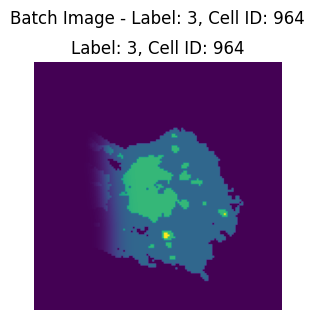

In [40]:
# Visualize a batch
visualize_batch(test_data_loader_big)

In [1]:
import os
os.chdir('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/')
files = os.listdir()
for file in files:
    print(file)
print("\n")

balanced_testset.pt
testset_0.h5
testset_1.h5
balanced_testset_big.pt
testset_indices.pkl
testset_5.h5
testset_3.h5
testset_4.h5
balanced_testset_old.pt
testset_2.h5




# Make BIG final balanced testset with 100000 instances for class 5 and 2000 for all other classes WITH return_id = true (100k testset)

#### used across de novo model and ConvNeXt inference

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Function to create balanced testset with class 5 having 10,000 instances
def create_balanced_testset_big(dataset, target_classes, n_instances_per_class, class_5_instances):
    """
    Create a balanced testset where class 5 has 10,000 instances and other classes have n_instances_per_class.
    """
    balanced_data = []
    
    for cls in target_classes:
        print(f"Processing class {cls}...")
        class_indices = [i for i, (_, label, _) in enumerate(dataset) if label == cls]
        
        if cls == 5:
            sampled_indices = np.random.choice(class_indices, class_5_instances, replace=False)
        else:
            sampled_indices = np.random.choice(class_indices, n_instances_per_class, replace=False)
        
        balanced_data.extend([dataset[i] for i in sampled_indices])  # dataset[i] returns (image, label, cell_id)!
    
    # Shuffle the testset
    balanced_data = shuffle(balanced_data, random_state=42)  
    return balanced_data

In [21]:
# Define parameters
batch_size = 64
n_test_instances_per_class = 2000  # Test instances for classes 0-4
class_5_instances = 100000          # Test instances for class 5
target_test_classes = [0, 1, 2, 3, 4, 5]

In [22]:
testset_data = HDF5SingleCellDataset(
    dir_list=[
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
        '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5'
    ],
    dir_labels=[4, 4, 4, 5, 3, 3, 3, 0, 1, 2], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Selecting the 5th channel (channel index 4)
    return_id=True  # Now return_id is True to get the cell ids we want!!
)

Total: 789105
0: 100000
1: 100000
2: 100000
3: 5019
4: 3654
5: 480432


In [23]:
# Create new balanced testset
balanced_testset_big = create_balanced_testset_big(testset_data, target_test_classes, n_test_instances_per_class, class_5_instances)

# Create test DataLoader (shared for all training processes)
test_data_loader = DataLoader(balanced_testset_big, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

Processing class 0...
Processing class 1...
Processing class 2...
Processing class 3...
Processing class 4...
Processing class 5...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [30]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
/dev/vdb        500G  342G  159G  69% /
tmpfs           4.0M     0  4.0M   0% /sys/fs/cgroup
tmpfs           126G   20K  126G   1% /dev/shm
tmpfs           126G     0  126G   0% /tmp
tmpfs           126G     0  126G   0% /run
tmpfs           126G     0  126G   0% /run/lock
/dev/vda1        39G   15G   24G  39% /dss
tmpfs            26G  984K   26G   1% /etc/resolv.conf
tmpfs           126G   12K  126G   1% /proc/driver/nvidia
dsshome1        563T  199T  364T  36% /dss/dsshome1
dsslegfs02       48T   29T   20T  60% /dss/dsslegfs02
dssfs04         241T   63T  178T  27% /dss/dssfs04
dssmcmlfs01     188T  105T   83T  57% /dss/dssmcmlfs01
mcmlscratch     126T   16T  111T  13% /dss/mcmlscratch
dssfs02          12P  2.5P  8.7P  22% /dss/dssfs02
dssfs03          12P  1.8P  9.4P  16% /dss/dssfs03
dsslegfs01      1.9P  802T  1.1P  43% /dss/dsslegfs01
dssfs05         6.3P  615G  6.3P   1% /dss/dssfs05


In [24]:
# Extract labels correctly (ignoring image and cell ID)
test_labels = [label for _, label, _ in balanced_testset_big]

# Compute class distribution
unique, counts = np.unique(test_labels, return_counts=True)
print(f"Test set class distribution (balanced): {dict(zip(unique, counts))}")

Test set class distribution (balanced): {0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 100000}


In [34]:
def save_dataset(dataset, save_path):
    images_tensor = torch.stack([sample[0] for sample in dataset])
    labels_tensor = torch.tensor([sample[1] for sample in dataset])
    cell_ids_tensor = torch.tensor([sample[2] for sample in dataset])
    torch.save((images_tensor, labels_tensor, cell_ids_tensor), save_path)
    print(f"Dataset saved at {save_path}")

In [36]:
save_dataset(
    balanced_testset_big,
    "/dss/dsshome1/0F/di93quv/balanced_testset_big_100k.pt"
)

Dataset saved at /dss/dsshome1/0F/di93quv/balanced_testset_big_100k.pt


In [37]:
def load_dataset(save_path, batch_size):
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)
    dataset = TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Loaded dataset from {save_path}")
    return data_loader

In [38]:
# Load the new dataset
test_data_loader_big = load_dataset(
    "/dss/dsshome1/0F/di93quv/balanced_testset_big_100k.pt",
    batch_size=batch_size
)

Loaded dataset from /dss/dsshome1/0F/di93quv/balanced_testset_big_100k.pt


In [39]:
# Function to visualize a batch
def visualize_batch(data_loader):
    images, labels, cell_ids = next(iter(data_loader))
    image_data = images[0].numpy()
    label = labels[0].item()
    cell_id = cell_ids[0].item()
    num_channels = image_data.shape[0]
    
    if num_channels == 1:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        ax.imshow(image_data[0]) 
        ax.set_title(f"Label: {label}, Cell ID: {cell_id}")
        ax.axis('off')
    else:
        fig, axes = plt.subplots(1, num_channels, figsize=(10, 5))
        for channel in range(num_channels):
            axes[channel].imshow(image_data[channel])
            axes[channel].set_title(f"Channel {channel + 1}")
            axes[channel].axis('off')
        
    plt.tight_layout()
    plt.suptitle(f"Batch Image - Label: {label}, Cell ID: {cell_id}", y=1.05)
    plt.show()

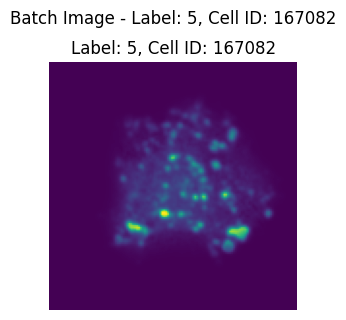

In [40]:
# Visualize a batch
visualize_batch(test_data_loader_big)

## Make the LRZ Random Subset Screening testset

Other classes are not included here, this is used for the active leanring loop!

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Function to create balanced testset with class 5 having 10,000 instances
def create_balanced_testset_big(dataset, target_classes, n_instances_per_class, class_5_instances):
    """
    Create a balanced testset where class 5 has 10,000 instances and other classes have n_instances_per_class.
    """
    balanced_data = []
    
    for cls in target_classes:
        print(f"Processing class {cls}...")
        class_indices = [i for i, (_, label, _) in enumerate(dataset) if label == cls]
        
        if cls == 5:
            sampled_indices = np.random.choice(class_indices, class_5_instances, replace=False)
        else:
            sampled_indices = np.random.choice(class_indices, n_instances_per_class, replace=False)
        
        balanced_data.extend([dataset[i] for i in sampled_indices])  # dataset[i] returns (image, label, cell_id)!
    
    # Shuffle the testset
    balanced_data = shuffle(balanced_data, random_state=42)  
    return balanced_data

In [10]:
# Define parameters
batch_size = 64
n_test_instances_per_class = 0  # Test instances for classes 0-4
class_5_instances = 100000          # Test instances for class 5
target_test_classes = [5]

In [11]:
testset_data = HDF5SingleCellDataset(
    dir_list=[
              #'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              #'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              #'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              #'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              #'/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
    ],
    dir_labels=[5], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/',
    select_channel=4,  # Selecting the 5th channel (channel index 4)
    return_id=True  # Now return_id is True to get the cell ids we want!!
)

Total: 480432
5: 480432


In [13]:
# Create new balanced testset
balanced_testset_big = create_balanced_testset_big(testset_data, target_test_classes, n_test_instances_per_class, class_5_instances)

# Create test DataLoader (shared for all training processes)
test_data_loader = DataLoader(balanced_testset_big, batch_size=batch_size, shuffle=True, num_workers=100, pin_memory=True)

Processing class 5...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 14, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
# Extract labels correctly (ignoring image and cell ID)
test_labels = [label for _, label, _ in balanced_testset_big]

# Compute class distribution
unique, counts = np.unique(test_labels, return_counts=True)
print(f"Test set class distribution (balanced): {dict(zip(unique, counts))}")

Test set class distribution (balanced): {5: 100000}


In [15]:
def save_dataset(dataset, save_path):
    images_tensor = torch.stack([sample[0] for sample in dataset])
    labels_tensor = torch.tensor([sample[1] for sample in dataset])
    cell_ids_tensor = torch.tensor([sample[2] for sample in dataset])
    torch.save((images_tensor, labels_tensor, cell_ids_tensor), save_path)
    print(f"Dataset saved at {save_path}")

In [17]:
save_dataset(
    balanced_testset_big,
    "/dss/dsshome1/0F/di93quv/LRZ_Random_Screening_subset_100k.pt"
)

Dataset saved at /dss/dsshome1/0F/di93quv/LRZ_Random_Screening_subset_100k.pt


In [14]:
def load_dataset(save_path, batch_size):
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)
    dataset = TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Loaded dataset from {save_path}")
    return data_loader

In [15]:
# Load the new dataset
test_data_loader_big = load_dataset(
    "/dss/dsshome1/0F/di93quv/LRZ_Random_Screening_subset_100k.pt",
    batch_size=batch_size
)

Loaded dataset from /dss/dsshome1/0F/di93quv/LRZ_Random_Screening_subset_100k.pt


In [16]:
# Function to visualize a batch
def visualize_batch(data_loader):
    images, labels, cell_ids = next(iter(data_loader))
    image_data = images[0].numpy()
    label = labels[0].item()
    cell_id = cell_ids[0].item()
    num_channels = image_data.shape[0]
    
    if num_channels == 1:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        ax.imshow(image_data[0]) 
        ax.set_title(f"Label: {label}, Cell ID: {cell_id}")
        ax.axis('off')
    else:
        fig, axes = plt.subplots(1, num_channels, figsize=(10, 5))
        for channel in range(num_channels):
            axes[channel].imshow(image_data[channel])
            axes[channel].set_title(f"Channel {channel + 1}")
            axes[channel].axis('off')
        
    plt.tight_layout()
    plt.suptitle(f"Batch Image - Label: {label}, Cell ID: {cell_id}", y=1.05)
    plt.show()

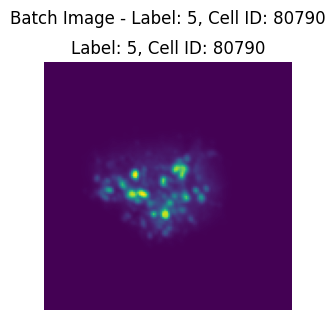

In [17]:
# Visualize a batch
visualize_batch(test_data_loader_big)